Здесь будем фигачить признаки для деревьев, поэтому скоррелированные не выкидываем

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc

In [2]:
from scipy import stats

In [3]:
sns.set_context('talk')

In [4]:
pd.set_option('display.max_columns', 500)

In [5]:
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

# Read the data

In [6]:
test = pd.read_csv('csv/ech_test.csv', sep=';', index_col='id')
train = pd.read_csv('csv/ech_apprentissage.csv', sep=';', index_col='id')

/home/alexey/.environments/ml/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Graphs

In [7]:
train.columns

Index(['annee_naissance', 'annee_permis', 'marque', 'puis_fiscale', 'anc_veh',
       'codepostal', 'energie_veh', 'kmage_annuel', 'crm', 'profession',
       'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9',
       'var10', 'var11', 'var12', 'var13', 'var14', 'var15', 'var16', 'var17',
       'var18', 'var19', 'var20', 'var21', 'var22', 'prime_tot_ttc'],
      dtype='object')

Заменим NR на NaN

In [8]:
train.replace('NR', np.NaN, inplace=True)
test.replace('NR', np.NaN, inplace=True)

Заменим ARMEE в codepostal на -1

In [9]:
train.loc[train.codepostal == 'ARMEE', 'codepostal'] = '-1'

In [10]:
train.loc[train.codepostal == '-1', 'codepostal']

id
46294    -1
46295    -1
46296    -1
Name: codepostal, dtype: object

Переведём codepostal в числа

In [11]:
train.codepostal = pd.to_numeric(train.codepostal)

In [12]:
test.codepostal.dtype

dtype('int64')

С тестом всё норм

Разделим codepostal на часть, относящуюся к региону, и на остальное. Учтём всякие крайние случаи типа заморских территорий.

In [13]:
def split_postcode(df):
    df['department'] = df['codepostal'] // 1000
    df['subreg'] = df['codepostal'] % 1000
    overseas = (df['department'] == 98) | (df['department'] == 97)
    df.ix[overseas, 'department'] = df['codepostal'] // 100
    df.ix[overseas, 'subreg'] = df['codepostal'] % 100
    df['ext_dep'] = df['codepostal'] // 100
    return df.drop('codepostal', axis=1)

In [14]:
train = split_postcode(train)

In [15]:
test = split_postcode(test)

Посмотрим на категориальные

In [16]:
categorical = []
for col in train.columns:
    if train[col].dtype not in ['int64', 'float64']:
        print(col, train[col].dtype)
        categorical.append(col)

marque object
energie_veh object
profession object
var6 object
var7 object
var8 object
var14 object
var16 object


In [17]:
for col in categorical:
    print(col, '\n', set(train[col]), '\n\n')

marque 
 {nan, 'PONCIN', 'AMPHICAR', 'MAZDA', 'MEGA', 'MVS', 'CHEYENNE', 'PORSCHE', 'ROLLS ROYCE', 'TRIUMPH', 'SIMCA', 'ASTON MARTIN', 'CARBODIES', 'LORENZ', 'ENGIN TRAVAUX PUBLIC', 'BREMACH', 'SEAT', 'SSANGYONG', 'LOHR', 'IVECO', 'BERTONE', 'VEH SPECIAL', 'ACMA', 'HANOMAG', 'YAMAHA', 'TALBOT', 'CADILLAC', 'SANTANA', 'TATA', 'ASIA', 'MARUTI', 'SUZUKI', 'CATERHAM', 'CHEVROLET', 'PIAGGIO', 'JAGUAR', 'AUSTIN-HEALEY', 'LDV', 'LOTUS', 'AUTOBIANCHI', 'KIA', 'SECMA', 'LAFER', 'RAYTON FISSORE', 'PLYMOUTH', 'MOKE', 'RAMBLER', 'INFINITI', 'DETHLEFFS', 'EAGLE', 'EBS', 'AUVERLAND', 'FERRARI', 'LANCIA', 'HONDA', 'HOTCHKISS', 'DE LOREAN', 'VOLVO', 'STRAUBENHARDT', 'SMS', 'DANGEL', 'AMC', 'COURNIL', 'PONTIAC', 'JIDE', 'DELAHAYE', 'DAIMLER', 'MERCEDES', 'MCC', 'PANHARD', 'BUICK', 'DACIA', 'VAUXHALL', 'ALPINE RENAULT', 'MORRIS', 'FIAT', 'PGO', 'AUSTIN', 'ARO', 'LAND-ROVER', 'AUTOLAND', 'TVR', 'SKODA', 'SAAB', 'CHENARD ET WALKER', 'GRANDIN', 'MITSUBISHI', 'SINGER', 'LAMBORGHINI', 'OPEL', 'FORD', 'BRM', 

Переведём в численные те признаки, которые посчитались за категориальные, потому что в них был NR (var7, var16). 

In [18]:
train.var7 = pd.to_numeric(train.var7)
train.var16 = pd.to_numeric(train.var16)

In [19]:
test.var7 = pd.to_numeric(test.var7)
test.var16 = pd.to_numeric(test.var16)

Опять посмотрим, но сразу с тестом

In [20]:
categorical = []
bigX = pd.concat([train.drop('prime_tot_ttc', axis=1), test])
for col in bigX.columns:
    if bigX[col].dtype not in ['int64', 'float64']:
        categorical.append(col)
for col in categorical:
    s = set(bigX[col])
    print(col, len(s), '\n', s, '\n\n')        

marque 157 
 {nan, 'PONCIN', 'AMPHICAR', 'MAZDA', 'MEGA', 'MVS', 'CHEYENNE', 'PORSCHE', 'ROLLS ROYCE', 'TRIUMPH', 'SIMCA', 'ASTON MARTIN', 'CARBODIES', 'LORENZ', 'ENGIN TRAVAUX PUBLIC', 'BREMACH', 'SEAT', 'SSANGYONG', 'LOHR', 'IVECO', 'BERTONE', 'VEH SPECIAL', 'ACMA', 'HANOMAG', 'YAMAHA', 'TALBOT', 'CADILLAC', 'SANTANA', 'TATA', 'ASIA', 'MARUTI', 'SUZUKI', 'CATERHAM', 'CHEVROLET', 'PIAGGIO', 'JAGUAR', 'AUSTIN-HEALEY', 'LDV', 'LOTUS', 'AUTOBIANCHI', 'KIA', 'SECMA', 'LAFER', 'RAYTON FISSORE', 'PLYMOUTH', 'MOKE', 'RAMBLER', 'INFINITI', 'DETHLEFFS', 'EAGLE', 'EBS', 'AUVERLAND', 'FERRARI', 'LANCIA', 'HONDA', 'HOTCHKISS', 'DE LOREAN', 'VOLVO', 'STRAUBENHARDT', 'SMS', 'DANGEL', 'AMC', 'COURNIL', 'PONTIAC', 'JIDE', 'DELAHAYE', 'DAIMLER', 'MERCEDES', 'MCC', 'PANHARD', 'BUICK', 'DACIA', 'VAUXHALL', 'ALPINE RENAULT', 'MORRIS', 'FIAT', 'PGO', 'AUSTIN', 'ARO', 'LAND-ROVER', 'AUTOLAND', 'TVR', 'SKODA', 'SAAB', 'CHENARD ET WALKER', 'GRANDIN', 'MITSUBISHI', 'SINGER', 'LAMBORGHINI', 'OPEL', 'FORD', 'BR

В категорию маломощных категориалов выделяются var14, var6, energie_veh.

Средние var8, proffession

Большие marque

## var1 -- стаж == 2016 - annee_permis

Думаю, annee_permis можно выкинуть, так как важны возраст и стаж

In [21]:
train['age'] = 2016 - train['annee_naissance']
test['age'] = 2016 - test['annee_naissance']

In [22]:
train.drop(['annee_naissance', 'annee_permis'], axis=1, inplace=True)
test.drop(['annee_naissance', 'annee_permis'], axis=1, inplace=True)

## var9 -- мощность в лошадиных силах

Забавно, var11 почти полностью повторяет anc_veh. Только иногда встречаются пары (0, 33)

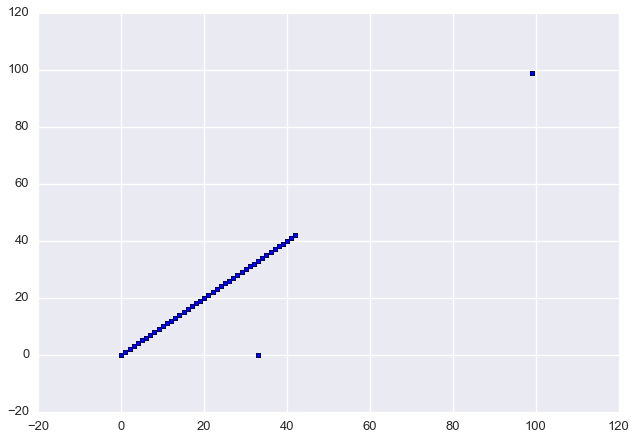

In [27]:
plt.scatter(train.var11, train.anc_veh)

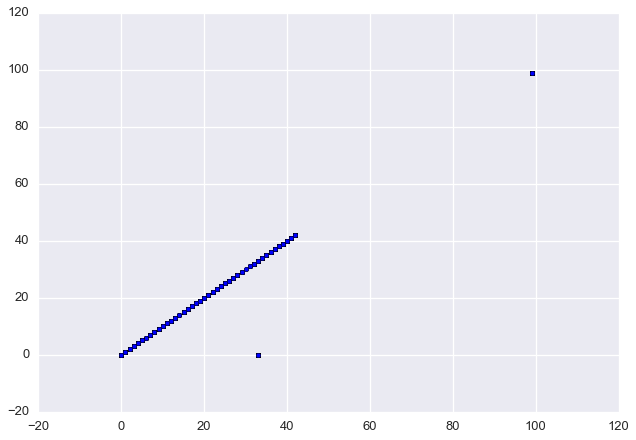

In [28]:
plt.scatter(test.var11, test.anc_veh)

Ну нахер, просто выбросим var11 (попробуем выбросить при обучении)

## kmage_annuel -- ограничение на километраж за год

На форумах говорят, что от налога на лошадиные силы зависят линеные добавки к цене. Вот же зараза-то какая. Придётся вернуться к обычному таргету, да ещё вернуть crm

Ещё на форумах говорят, что сильно зависит от марки и возраста машины

## var12 -- вес

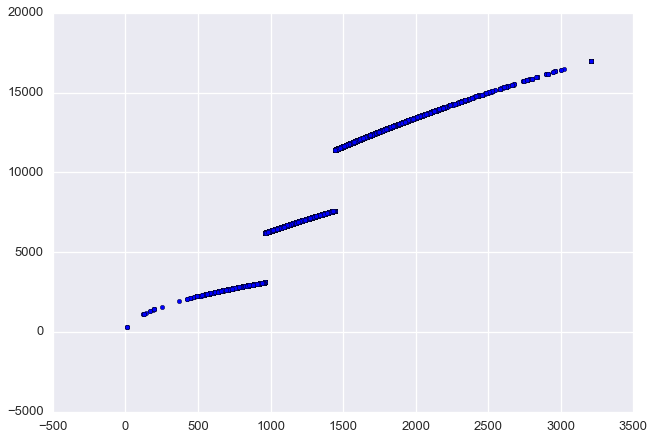

In [23]:
plt.scatter(train.var12, train.kmage_annuel)

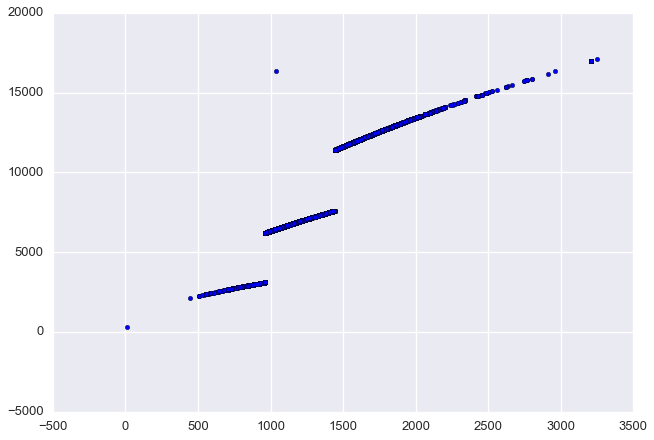

In [24]:
plt.scatter(test.var12, test.kmage_annuel)

В трейне kmage_annuel монотонная функция от var12. Выкинем var12

In [25]:
train.drop('var12', axis=1, inplace=True)
test.drop('var12', axis=1, inplace=True)

# Target label separation 

In [32]:
y_train = train['prime_tot_ttc']
train = train.drop('prime_tot_ttc', axis=1)

# Save to file

In [33]:
y_train.to_csv('preprocessed_csv/y_train_4.csv', sep=';')

In [34]:
train.to_csv('preprocessed_csv/train_4.csv', sep=';')

In [35]:
test.to_csv('preprocessed_csv/test_4.csv', sep=';')